# 1.4c: Distance Distribution

This notebook analyzes the distribution of pairwise distances within the overdensity to reveal its internal structure.

## The Question

We've computed ~208 million pairwise distances between the ~20,000 tokens in the overdensity (1.4b). Now we ask:

- **What does the distance distribution look like?**
- Are there tokens that are **extremely close** together?
- Are there **exact duplicates** (distance = 0)?

If we see a concentration of very small distances, that indicates a truly dense cluster—tokens packed much closer than normal vocabulary separation. If we see exact zeros, that means multiple tokens occupy the same point in space.

## Method

We'll:
1. Load the distance matrix from 1.4b
2. Examine basic statistics (min, max, percentiles)
3. Plot a histogram of the full distribution
4. Count pairs below various distance thresholds
5. Check for exact zeros
6. Plot a zoomed histogram to examine fine structure

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Full histogram
HIST_BINS = 100

# Zoomed histogram (set None to skip)
ZOOM_XMIN = 0.0
ZOOM_XMAX = 0.01
ZOOM_BINS = 50

# Visualization
FIGSIZE = (12, 6)
DPI = 200

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Load Distance Matrix

In [3]:
# Load distances and token IDs from 1.4b
tensor_path = Path(f"../tensors/{MODEL_NAME}/1.4b_overdensity_distances.safetensors")
data = load_file(tensor_path)
dists = data['distances']
spike_token_ids = data['spike_token_ids']

print(f"Loaded distance matrix from {tensor_path}")
print(f"  Shape: {dists.shape}")
print(f"  Tokens: {len(spike_token_ids):,}")
print(f"  Memory: {dists.element_size() * dists.nelement() / 1024**3:.2f} GB")

Loaded distance matrix from ../tensors/Qwen3-4B-Instruct-2507/1.4b_overdensity_distances.safetensors
  Shape: torch.Size([20373, 20373])
  Tokens: 20,373
  Memory: 1.55 GB


## Extract Upper Triangle

The distance matrix is symmetric, so we only need the upper triangle (excluding the diagonal, which is all zeros).

In [4]:
# Get upper triangle (excluding diagonal)
upper_tri_mask = torch.triu(torch.ones_like(dists, dtype=torch.bool), diagonal=1)
dists_upper = dists[upper_tri_mask]

print(f"Upper triangle distances:")
print(f"  Number of pairs: {len(dists_upper):,}")
print(f"  Memory: {dists_upper.element_size() * dists_upper.nelement() / 1024**3:.2f} GB")

Upper triangle distances:
  Number of pairs: 207,519,378
  Memory: 0.77 GB


## Distance Statistics

In [5]:
print(f"Distance statistics:\n")

# Convert to numpy for stats
dists_np = dists_upper.numpy()

# Basic stats
print(f"  Min:     {dists_np.min():.10f}")
print(f"  Max:     {dists_np.max():.10f}")
print(f"  Mean:    {dists_np.mean():.10f}")
print(f"  Median:  {np.median(dists_np):.10f}")
print(f"  Std:     {dists_np.std():.10f}")
print()

# Percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print(f"  Percentiles:")
for p in percentiles:
    val = np.percentile(dists_np, p)
    print(f"    p{p:2d}: {val:.10f}")

Distance statistics:

  Min:     0.0000000000
  Max:     2.0540900230
  Mean:    1.1983120441
  Median:  1.2463527918
  Std:     0.3468301296

  Percentiles:
    p 1: 0.0000349753
    p 5: 0.4889051914
    p10: 0.7553980350
    p25: 1.0386644602
    p50: 1.2463527918
    p75: 1.4535273314
    p90: 1.5765862465
    p95: 1.6347508430
    p99: 1.7269314528


## Full Distribution Histogram


Creating full distribution histogram...



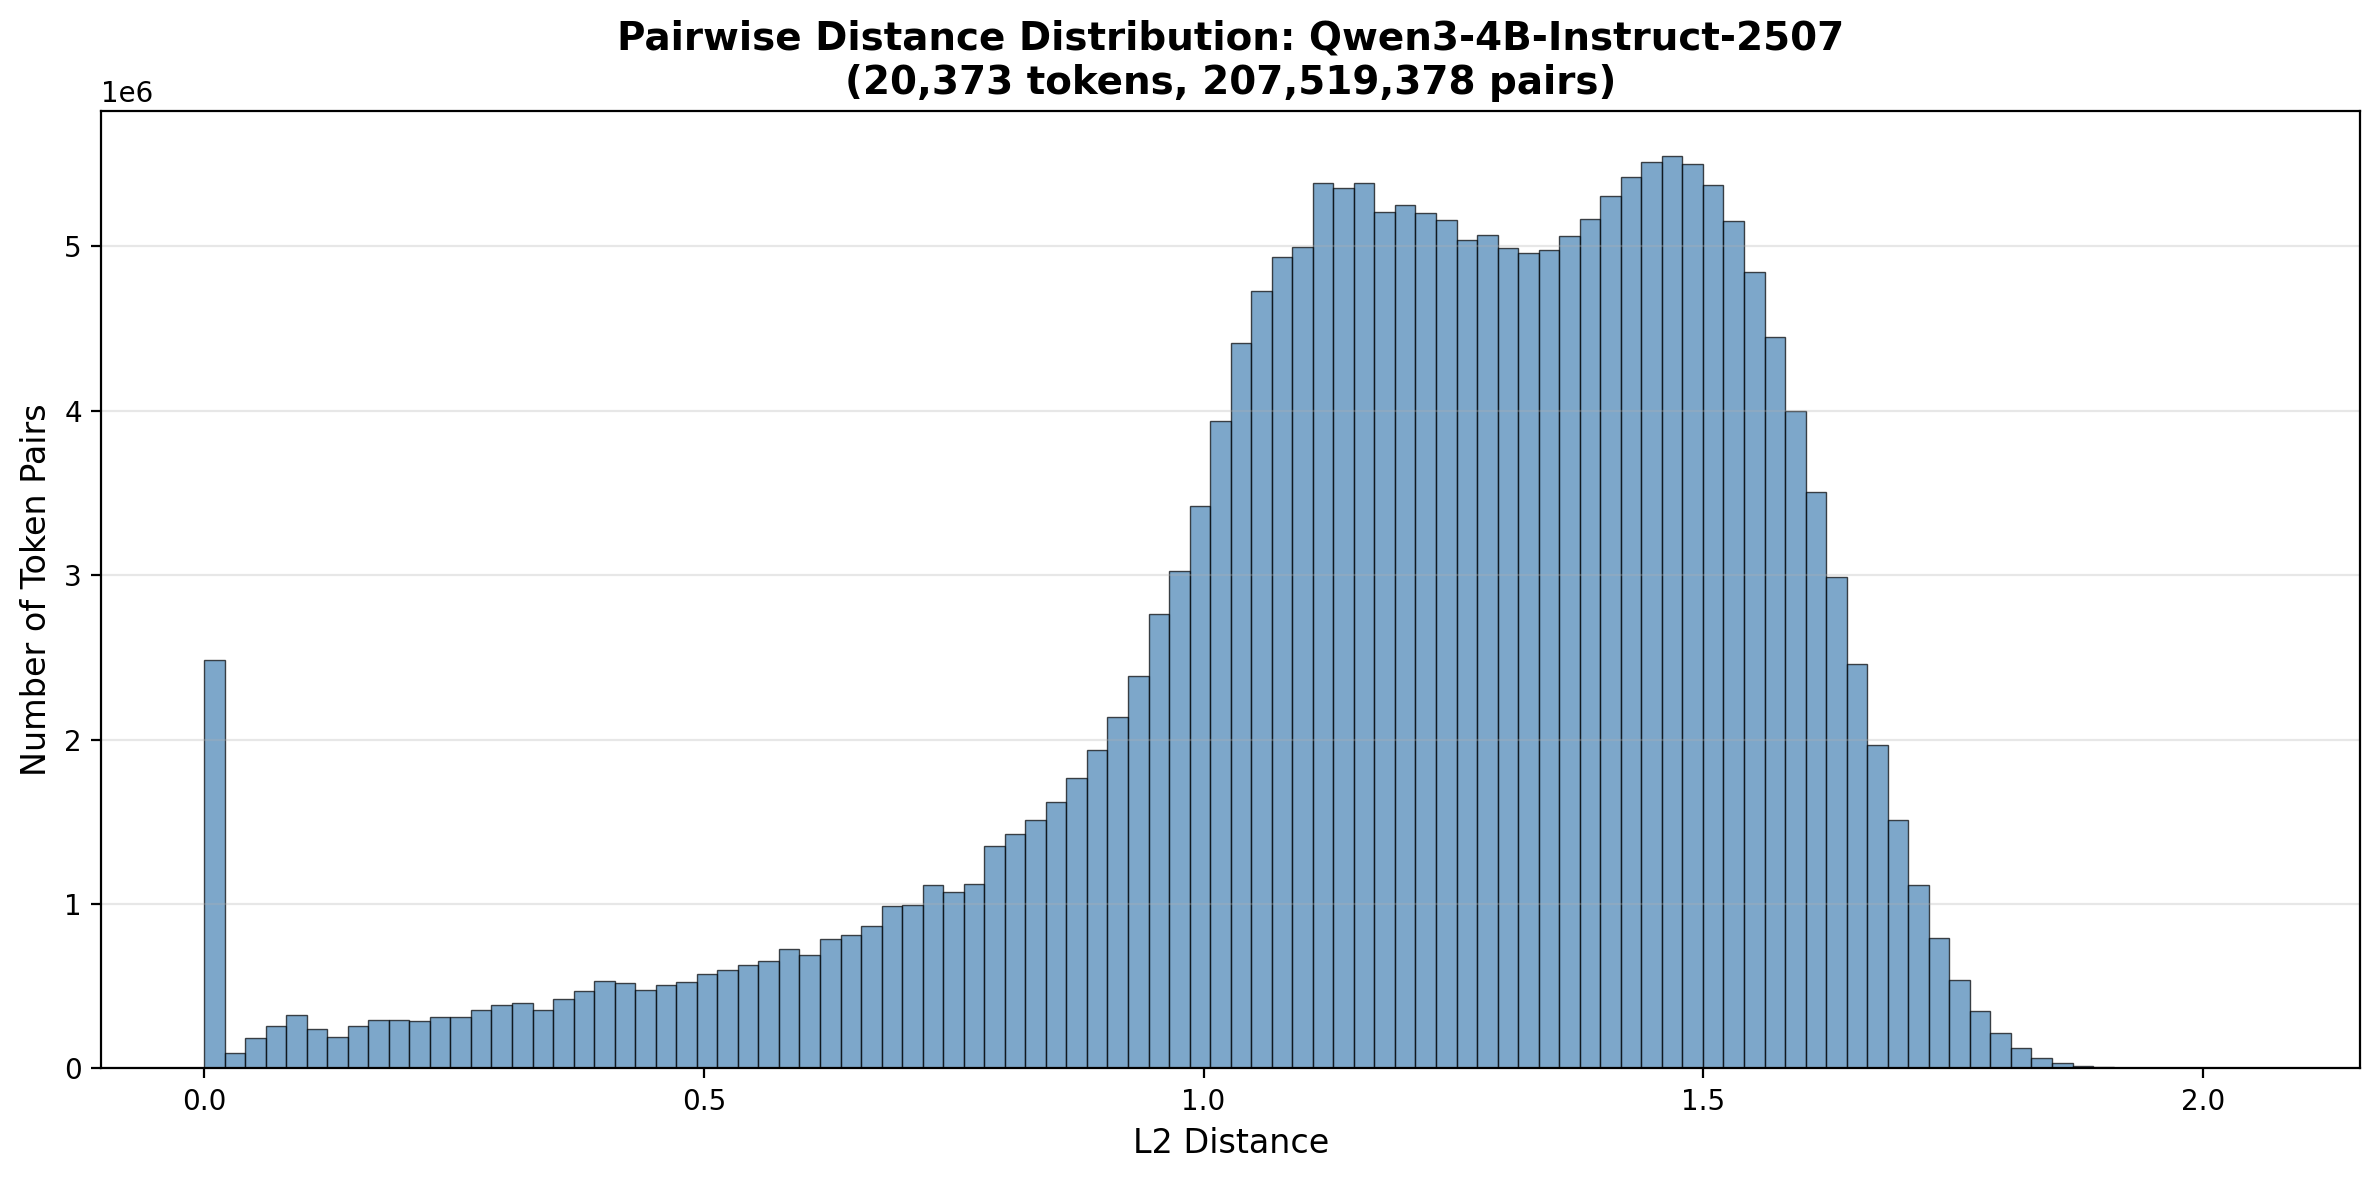

✓ Full histogram complete


In [6]:
print(f"\nCreating full distribution histogram...\n")

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Histogram (dists_np already created in previous cell)
ax.hist(dists_np, bins=HIST_BINS, color='steelblue', alpha=0.7, 
        edgecolor='black', linewidth=0.5)

# Formatting
ax.set_xlabel('L2 Distance', fontsize=12)
ax.set_ylabel('Number of Token Pairs', fontsize=12)
ax.set_title(f'Pairwise Distance Distribution: {MODEL_NAME}\n({len(spike_token_ids):,} tokens, {len(dists_upper):,} pairs)',
             fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Full histogram complete")

## Small Distance Examination

How many token pairs are extremely close together? Let's count pairs below various thresholds.

In [7]:
print(f"\nCounting pairs below distance thresholds:\n")

# Thresholds to examine
thresholds = [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2, 1e-1]

print(f"{'Threshold':<15} {'Pairs Below':<15} {'Percentage'}")
print("-" * 50)

for thresh in thresholds:
    count = (dists_upper < thresh).sum().item()
    pct = count / len(dists_upper) * 100
    print(f"{thresh:<15.0e} {count:<15,} {pct:>6.2f}%")

print()
print(f"Total pairs: {len(dists_upper):,}")


Counting pairs below distance thresholds:

Threshold       Pairs Below     Percentage
--------------------------------------------------
1e-10           651,034           0.31%
1e-08           658,066           0.32%
1e-06           678,292           0.33%
1e-04           2,380,970         1.15%
1e-03           2,440,917         1.18%
1e-02           2,465,293         1.19%
1e-01           3,317,475         1.60%

Total pairs: 207,519,378


## Exact Zeros

How many token pairs have distance **exactly zero**? These are duplicates—multiple tokens at the same point in space.

In [8]:
# Count exact zeros
n_zeros = (dists_upper == 0).sum().item()

print(f"\nExact zeros (off-diagonal):")
print(f"  Count: {n_zeros:,}")
print(f"  Percentage: {n_zeros / len(dists_upper) * 100:.4f}%")
print()

if n_zeros > 0:
    print(f"⚠️  Found {n_zeros:,} token pairs with distance = 0")
    print(f"   This means multiple tokens occupy the same point in space!")
    print(f"   These are degenerate embeddings—different tokens with identical vectors.")
else:
    print(f"✓ No exact duplicates found (all tokens have unique embeddings)")


Exact zeros (off-diagonal):
  Count: 651,034
  Percentage: 0.3137%

⚠️  Found 651,034 token pairs with distance = 0
   This means multiple tokens occupy the same point in space!
   These are degenerate embeddings—different tokens with identical vectors.


## Zoomed Histogram

Examine a specific distance range in detail.


Creating zoomed histogram: [0.0, 0.01]

Pairs in range: 2,465,293 (1.19% of total)



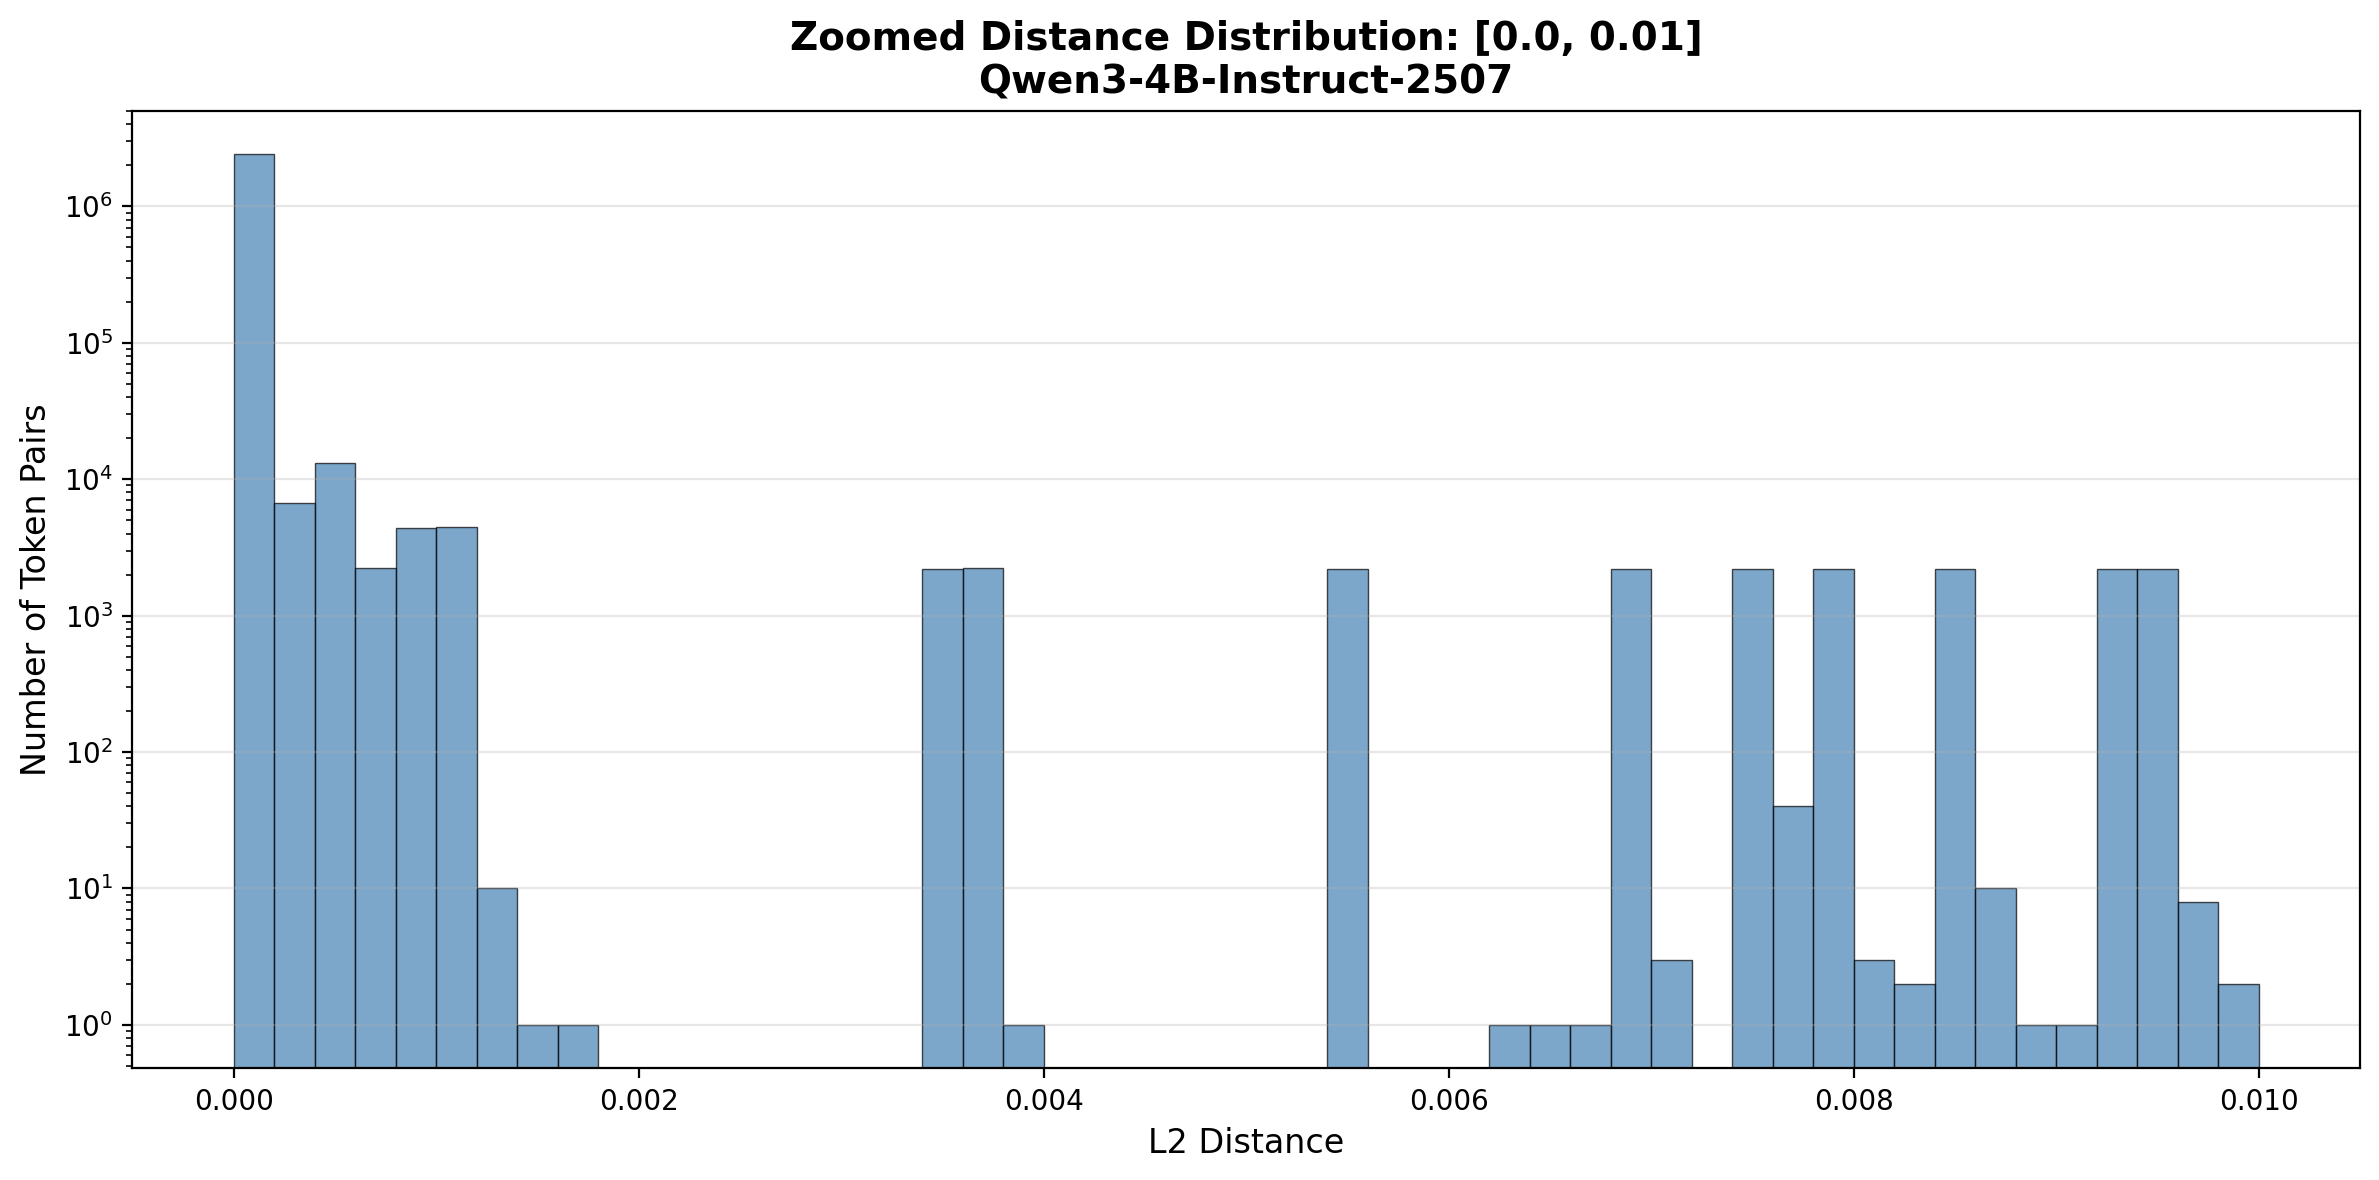

✓ Zoomed histogram complete


In [10]:
if ZOOM_XMIN is not None and ZOOM_XMAX is not None:
    print(f"\nCreating zoomed histogram: [{ZOOM_XMIN}, {ZOOM_XMAX}]\n")
    
    # Filter to zoom range
    zoom_mask = (dists_np >= ZOOM_XMIN) & (dists_np <= ZOOM_XMAX)
    dists_zoom = dists_np[zoom_mask]
    
    print(f"Pairs in range: {len(dists_zoom):,} ({len(dists_zoom)/len(dists_np)*100:.2f}% of total)\n")
    
    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
    
    # Histogram with explicit range
    ax.hist(dists_zoom, bins=ZOOM_BINS, range=(ZOOM_XMIN, ZOOM_XMAX),
            color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Formatting
    ax.set_xlabel('L2 Distance', fontsize=12)
    ax.set_ylabel('Number of Token Pairs', fontsize=12)
    ax.set_title(f'Zoomed Distance Distribution: [{ZOOM_XMIN}, {ZOOM_XMAX}]\n{MODEL_NAME}',
                 fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Zoomed histogram complete")
else:
    print("\nZoomed histogram skipped (set ZOOM_XMIN and ZOOM_XMAX to enable)")

## Observations

Look for:
- **Spike at small distances**: A concentration near zero indicates a tight cluster
- **Exact zeros**: Degenerate embeddings ("black holes")
- **Bimodal distribution**: Tight cluster + normal separation
- **Gap**: Clear separation between clustered tokens and normal tokens

The distance distribution reveals the internal structure of the overdensity—whether it's a single tight cluster, multiple clusters, or a continuous distribution.